# Training an MLP

This notebook is based on [Andrej Karpathy's excellent micrograd tutorial](https://github.com/karpathy/micrograd) and Joerg Frochte's book "Maschinelles Lernen: Grundlagen und Algorithmen in Python", 3rd edition.

## Recap: Multi-Layer Perceptron (MLP)
Recall that a perceptron can only distinguish between members of class A and members of class B **if** these **classes are linearly separable**.

In the 1960, this led to a search for classification approaches using **multi-layer perceptrons**. The researchers found that an MLP with just **2 adjustable layers** of weights can correctly classify **any finite number of classes** if there is a sufficient number of "hidden" perceptrons in the layer mediating between the input vector and the output unit.

Unfortunately, for fewer hidden perceptrons than cases to be learned, no even moderately efficient algorithm for systematically computing the weights could be found. Eventually, researchers came up with an algorithm known as **backpropagation** (**BP**) based on the concept of derivation known from calculus.

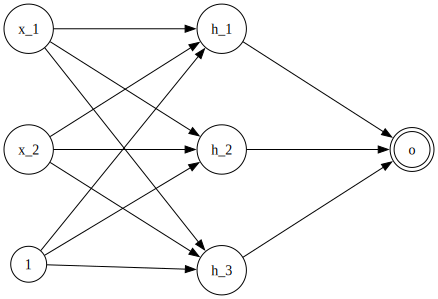

In [4]:
%matplotlib inline
from graphviz import Digraph

# Create a new directed graph
dot = Digraph('multi-layer-perceptron-simplified', graph_attr={'rankdir': 'LR', 'ranksep': '2', 'nodesep': '1'}, comment='Multi-layer perceptron (simplified)')

# Add nodes for the input layer
for i in range(1, 3):
    dot.node(f'I{i}', f'x_{i}', shape='circle')

dot.node(f'I3', '1', shape='circle')

# Add nodes for the hidden layer
for i in range(1, 4):
    dot.node(f'H{i}', f'h_{i}', shape='circle')

# Add node for the output layer
dot.node('O', 'o', shape='doublecircle')

# Connect the nodes from the input layer to the hidden layer
for i in range(1, 3):
    for j in range(1, 4):
        dot.edge(f'I{i}', f'H{j}')

dot.edge(f'I3', f'H1')
dot.edge(f'I3', f'H2')
dot.edge(f'I3', f'H3')

# Connect the nodes from the hidden layer to the output layer
for i in range(1, 4):
    dot.edge(f'H{i}', 'O')

# Show the graph
dot

## Recap: Backpropagation

Recall that training a Multi-Layer-Perceptron (MLP) requires an algorithm known as **backpropagation** (**BP**). BP is essentially the **recursive application of the chain rule backwards through the propagation graph**. The chain rule says that if a variable $z$ depends on variable $y$, which, in turn, depends on the variable $x$, then $z$'s dependence on $x$ is:

$$\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}$$

So, BP first computes the function value and, using this value, computes backwards the gradients (i.e., the partial derivatives) for all intermediate nodes.

## Training the MLP

To train an MLP, we must find weights $W$ that give the best result. But how can we measure the performance of an MLP? Well, similar to a simple perceptron, for a given input $x$, we want the MLP to compute the output $y$ which is equal to the desired output $y_d$. Thus, given a **training set** $D = \{X, Y\}$, we want to **minimize** the [residual sum of squares](https://en.wikipedia.org/wiki/Residual_sum_of_squares)

$$L(W)=\sum_{y_D\in Y} \frac{1}{2} (y_D - y)^2$$

Note that $L(W)$ depends only on the weights $W$ that the MLP learns. Moreover, it makes sense to minimize $L(W)$ because, ultimately, if we could come up with weights $W$ for which the MLP always produces the correct output $y$, then $L(W)$ would be $0$. Hence, $L(W)$ is a single number to measure MLP's performance and it's called a **loss** or **loss function**.

If we want to use gradients (i.e., gradient descent) to find the minimum of $L(W)$, we must update the weights as:

$$W_{new} = W_{old} - \sigma \nabla L(W_{old})$$

where $\nabla$ is the gradient of $L$ (i.e., a vector of partial derivates of all inputs of $L$):

$$\nabla = \left(\frac{\partial L}{\partial x_1}, \frac{\partial L}{\partial x_2}, \ldots, \frac{\partial L}{\partial x_n}\right)$$

Because the $\nabla$-operator is linear (and because we can apply the chain rule), it holds that:

$$\nabla L(W)=\sum_{y_D\in Y} \frac{1}{2} \nabla (y_D - y)^2 = \sum_{y_D\in Y} \nabla (y_D - y)\cdot (-\nabla y) = - \sum_{y_D\in Y} (y_D - y) \nabla y$$

Using BP, we can compute these partial deliverables and, as a result, update the weights $W_{new}$ in order to learn the weights that minimize the loss function $L$.

## Training MLP, Spelled Out in Code

In [3]:
import math
import random

class Value:
    """Class that represents a value that can be differentiated in respect to other values.

    Attributes:
        data: The value itself.
        _prev: A set of values that this value is dependent on.
        _op: The operation that produced this value.
    """

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0 # derivative of the loss function in respect to this value
        self._backward = lambda: None # defines how to propagate the output gradient to the input gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        def _backward():
            # For addition, the local derivative is always 1. So, given the expression a = b + c, it follows from the chain rule 
            # dz/dx = dz/dy*dy/dx that the gradients of b and c are (1.0 * the gradient of a)
            if isinstance(other, Value):
                self.grad += 1.0 * out.grad
                other.grad += 1.0 * out.grad
            else:
                #print(f"__add__ backward for {self} and {other}")
                #print(f"uid(self)={id(self)}, uid(other)={id(other)}")
                self.grad += 1.0 * out.grad

        if isinstance(other, Value):
            out = Value(self.data + other.data, (self, other), '+')
            out._backward = _backward
            return out
        else:
            out = Value(self.data + other, (self,), '+')
            out._backward = _backward
            return out
        
    def __radd__(self, other):
        return self + other
        
    def __neg__(self): #-self
        return self * -1
        
    def __sub__(self, other): #self - other, uses __neg__ and __add__
        return self + (-other)
        
    def __mul__(self, other):
        def _backward():
            # For multiplication, the local derivative is always the other value (because for z=x*y, dz/dx = y). 
            # So, given the expression a = b * c, it follows from the chain rule that the gradient of b
            # is (c * the gradient of a), and the gradient of c is (b * the gradient of a).
            if isinstance(other, Value):
               self.grad += other.data * out.grad
               other.grad += self.data * out.grad
            else:
                #print(f"__mul__ backward for {self} and {other}")
                #print(f"uid(self)={id(self)}, uid(other)={id(other)}")
                self.grad += other * out.grad

        if isinstance(other, Value):
            out = Value(self.data * other.data, (self, other), '*')
            out._backward = _backward
            return out
        else:
            out = Value(self.data * other, (self,), '*')
            out._backward = _backward
            return out
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            #print(f"__pow__ backward for {self} and {other}")
            #print(f"uid(self)={id(self)}, uid(other)={id(other)}")
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other
    
    
    def __truediv__(self, other):
        return self * (other ** -1)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            #print(f"__tanh__ backward for {self}")
            #print(f"uid(self)={id(self)}")
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            #print(f"__exp__ backward for {self}")
            #print(f"uid(self)={id(self)}")
            self.grad += out.data * out.grad # because d/dx e^x = e^x
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0

        for node in reversed(topo):
            #print(f"In Value.backward(): processing node {node} of type {type(node)}")
            node._backward()

Using the `Value` class, we can now define the class `Neuron` to represent a single artificial neuron:

In [4]:
class Neuron:
    """Implementation of a neuron in a neural network."""

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1), label='w') for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1), label='b')

    def __call__(self, x):
        # compute raw activation w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

With the `Neuron` class in place, we can define the class `Layer` to represent a layer of neurons:

In [5]:
class Layer:
    """Implementation of a layer in a neural network."""

    def __init__(self, nin, nout):
        """Initialize a layer of nout neurons, each taking nin inputs."""
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for n in self.neurons:
            params.extend(n.parameters())

        return params

Finally, we can define an MLP:

In [6]:
class MLP:
    """Implementation of a multilayer perceptron."""

    def __init__(self, nin, nouts):
        """Initialize a MLP with nouts layers, each taking nin inputs.

        Args:
            nin: Number of inputs to the MLP.
            nouts: List of number of neurons in each layer (including the output layer).
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

With that we can create an MLP that has 3 inputs, to hidden layers with 4 neurons each, and 1 output:

In [7]:
x = [2.0, 3.0, -1.0]
m = MLP(3, [4, 4, 1])
m(x)
m.parameters()

[Value(data=0.23637993216219444, label=w),
 Value(data=-0.9317756352715012, label=w),
 Value(data=0.6731201416549839, label=w),
 Value(data=0.9487144513657142, label=b),
 Value(data=0.991129442483893, label=w),
 Value(data=0.7911943990965784, label=w),
 Value(data=0.7965899246198038, label=w),
 Value(data=-0.3213548836875648, label=b),
 Value(data=0.2439336329796098, label=w),
 Value(data=0.08384006885960393, label=w),
 Value(data=-0.3343776766378621, label=w),
 Value(data=-0.4730151355604306, label=b),
 Value(data=-0.37469466322200784, label=w),
 Value(data=-0.009103997388743235, label=w),
 Value(data=0.9799288253819181, label=w),
 Value(data=-0.33009951852483743, label=b),
 Value(data=0.13846401203000425, label=w),
 Value(data=-0.00916477252167458, label=w),
 Value(data=0.43597340400810647, label=w),
 Value(data=0.7436936358929318, label=w),
 Value(data=0.48644207943014295, label=b),
 Value(data=-0.4107845773288499, label=w),
 Value(data=-0.3292392123888963, label=w),
 Value(data=0.5

In **gradient descent** we are doing the following steps: 

1. Forward pass
2. Backward pass
3. Update the weights

And we repeat this loop several times until we are happy with the value of the loss function. Let's see gradient descent in action:

In [8]:
m = MLP(3, [4, 4, 1])

# Inputs to the MLP
xs = [
    [2.0, 3.0,  -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# Desired outputs (target outputs)
ys = [1.0, -1.0, -1.0, 1.0]

# Initial predictions of the MLP
ypred = [m(x) for x in xs]
print(f"[*] Initial predictions: {ypred}")

learning_rate = 0.05

for k in range(100):
    # forward pass
    ypred = [m(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))

    # backward pass
    # don't forget to reset the gradients!) if the problem is very simple, without resetting the gradients, the gradients will accumulate, but the descent will be faster...
    for p in m.parameters():
        p.grad = 0.0
    loss.backward()

    # update parameters
    for p in m.parameters():
        p.data -= learning_rate * p.grad # update the parameters (gradients)

    print(k, loss.data)

# What predictions does the model make now, after k rounds of gradient descent?
# Remember that the target outputs are 1.0, -1.0, -1.0, 1.0
ypred = [m(x) for x in xs]
print(f"[*] Final predictions: {ypred}")

[*] Initial predictions: [Value(data=-0.9630024218277902, label=), Value(data=-0.5732968153283398, label=), Value(data=-0.953809158309051, label=), Value(data=-0.9345343054069937, label=)]
0 7.780010688563344
1 7.490748148068295
2 6.789535189050534
3 4.016056509649505
4 0.7830160638950555
5 0.45007366549716454
6 0.3127403591282777
7 0.23653223756345418
8 0.18866834694421786
9 0.15607158718747194
10 0.1325696890458432
11 0.11489248847464466
12 0.10115485076514655
13 0.09019778478422573
14 0.08127160749563558
15 0.07387103736677544
16 0.06764374500233877
17 0.06233693326705325
18 0.05776474685558685
19 0.053787642983550224
20 0.05029891296405319
21 0.0472156300426895
22 0.044472421251929656
23 0.04201708968988261
24 0.03980747827506222
25 0.03780918419173464
26 0.035993867412177125
27 0.034337981263556194
28 0.032821807528759475
29 0.03142871443297446
30 0.030144579895212575
31 0.028957338795511517
32 0.027856624337538043
33 0.02683348153849545
34 0.025880136534253237
35 0.02498980945998